In [8]:
import numpy as np
import scipy
from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d
import pickle
import os
import astropy as ap
from astropy.cosmology import WMAP7

import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from matplotlib import rcParams
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib import rc
from matplotlib import colors
from __future__ import unicode_literals

rcParams["font.family"] = "DejaVu Sans"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
rcParams['xtick.major.pad']='10'
rcParams['ytick.major.pad']='10'
rcParams['font.size'] = 22
rcParams['axes.labelsize'] = 22
rcParams['axes.labelweight'] = 'bold'
rcParams['axes.titlesize'] = 17
rcParams['xtick.labelsize'] = 17
rcParams['ytick.labelsize'] = 17
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 1

['wise2010-W1', 'wise2010-W2', 'wise2010-W3', 'wise2010-W4']
34002.54044481694


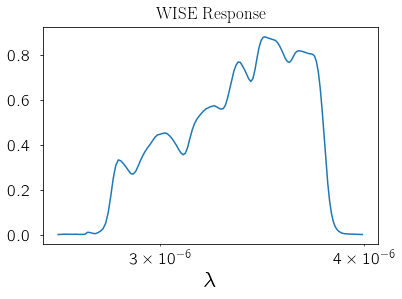

In [9]:
import speclite
from speclite import filters
wise = speclite.filters.load_filters('wise2010-*')
print(wise.names)
w1band = speclite.filters.load_filter('wise2010-W1')
w2band = speclite.filters.load_filter('wise2010-W2')
w3band = speclite.filters.load_filter('wise2010-W3')
w4band = speclite.filters.load_filter('wise2010-W4')
wave_w1 = (w1band.wavelength)*(10**(-10))
resp = w1band.response
eff = w1band.effective_wavelength.value
print(eff)

plt.plot(wave_w1,resp)
plt.xscale('log')
plt.xlabel(r'$\lambda$')
plt.title('WISE Response')
plt.show()

In [10]:
os.chdir('/Users/nitya/Work/Data/Project1/measurements')
print(os.getcwd())
afile = open(r'SFRP.pkl', 'rb')
d = pickle.load(afile, encoding = 'latin1')
afile.close()

# There's one annoying 0 thing in N band nmgy_ivar - removing it!
indf = np.where(np.asarray(d['NMGY_IVAR'])[:,1]>0)[0]
d  = np.asarray(d[indf])
ind, z, kc = d['NSAID'], d['Z'], d['KCORRECT']
opt = [d['ABSMAG'][:,1][i]-d['ABSMAG'][:,4][i] for i in range(len(ind))]
inf = [d['W1MAG'][i]-d['W3MAG'][i] for i in range(len(ind))]
h = binned_statistic_2d(inf,opt,ind,statistic = 'count',bins = (25,25))
bins = np.unique(h[3])

/Users/nitya/Work/Data/Project1/measurements


/usr/local/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [13]:
#Reading the Sedfit-files

os.chdir('/Users/nitya/Work/Data/Project1/magphys')
sed = []
float_vec = np.vectorize(np.float)

for i in range(len(bins)):
    f = str(bins[i]) + '.0' + '.sed'
    lines2 = open(f).readlines()[10:]
    se = np.asarray([float_vec(lines2[j].split()) for j in range(12816)])
    sed.append(se)

In [16]:
#The functions for convolving;

def f1(lam):
    x = lam/(1+z)
    fc = np.interp(x, 10**wav, spec)
    thing = lam*(10**fc)
    return thing

def f2(lam):
    fc = np.interp(lam, 10**wav, spec)
    thing = lam*(10**fc)
    return thing

In [18]:
sed = np.asarray(sed)

kc1 = []
kc2 = []
kc3 = []
kc4 = []

for i in range(len(z)):
    
    #Figuring out which bin the galaxy falls in;
    index = np.where(bins==h[3][i])[0]
    #Picking the corresponding SED template
    l = np.reshape(sed[index],(12816,3))
    z = d['Z'][i]
    
    wav = l[:,0]
    spec = l[:,1]
    
    a1 = w1band.convolve_with_function(f1)
    c1 = w1band.convolve_with_function(f2)
    kcorr1 = np.float(-2.5*(np.log10((1/(1+z))*a1/c1)))
    kc1.append(kcorr1)

    a2 = w2band.convolve_with_function(f1)
    c2 = w2band.convolve_with_function(f2)
    kcorr2 = np.float(-2.5*(np.log10((1/(1+z))*a2/c2)))
    kc2.append(kcorr2)

    a3 = w3band.convolve_with_function(f1)
    c3 = w3band.convolve_with_function(f2)
    kcorr3 = np.float(-2.5*(np.log10((1/(1+z))*a3/c3)))
    kc3.append(kcorr3)

    a4 = w4band.convolve_with_function(f1)
    c4 = w4band.convolve_with_function(f2)
    kcorr4 = np.float(-2.5*(np.log10((1/(1+z))*a4/c4)))
    kc4.append(kcorr4)
    

print(kc1[0:5])
print(kc2[0:5])
print(kc3[0:5])
print(kc4[0:5])

[-0.05466450354910872, -0.10820101812799084, -0.10421272543628793, -0.07697720218248856, -0.09922020444623458]
[-0.05966528790860215, -0.09400617482163479, -0.09708219519900083, -0.06793130520404803, -0.11391084324893458]
[-0.010038675424990963, -0.06805949360419382, -0.06591231154079007, -0.06734359095821746, -0.03097896348021289]
[-0.010475466305087945, 0.10050388212249939, 0.0792310080128926, 0.08322197374140583, 0.07875905237427365]
